# Jupyter Notebook for Validation of Results

## Overview

This notebook compares the results obtained from the two implementations, `shbundle` and `pyshbundle`, for a specific task.<br>
We will focus on evaluating the following:
1. Root Mean Squared Error (RMSE)
2. Normalized Root Mean Squared Error (NRMSE)
3. Difference in global area weighted water budget closure.
4. The difference in time series for a given basin.

## Evaluation Metrics

### 1. Root Mean Squared Error (RMSE)

The RMSE is a measure of the average magnitude of the errors between predicted and observed values.<br> It is calculated as follows:

$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big({y_i - \bar{y}}\Big)^2}}$$

where:
- $n$ is the number of observations
- ${y_i}$ is the $i_{th}$ observation
- $\bar{y}$ is the mean of observations

### 2. Normalized Root Mean Squared Error (NRMSE)

NRMSE is a normalized version of RMSE, which provides a relative measure of the error compared to the range of the observed values. It is calculated as:

$$ NRMSE = \frac{RMSE}{\max(y) - \min(y)}$$

### 3. Difference in global area weighted water budget closure.

Since the total mass of Earth is conserved (at the accuracy we can currently observe), the mass change observed over any month should sum up to zero. To verify this, we area weight the solutions from `shbundle` & `pyshbundle` using the area_weighting() function by creating a global area grid. Then we multiply this with the global solutions at each time step and take the average, followed by plotting the results.

### 4. Difference in basin-average Time Series

Finally we create a basin-average TWSA time-series from both the implementations.

## Data Preparation

Before proceeding with the analysis, ensure that the data from both `shbundle` and `pyshbundle` are loaded into the notebook.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os

In [3]:
''' Load tws processed data from shbundle as .mat file & from pyshbundle as xarray dataset '''
import scipy.io
# Load the .mat file
data = scipy.io.loadmat('../pyshbundle/data/validation_data/tws_sh.mat')

# Access the variables in the .mat file
var1 = data['tws_m']

temp=xr.open_dataset('../examples/tws_pysh.nc', engine="netcdf4")

var2=temp.tws.values

array([[[  -2.5984123,   -2.5491967,   -2.4989052, ...,   -2.7395167,
           -2.693581 ,   -2.6465435],
        [  -8.085175 ,   -7.9737053,   -7.859015 , ...,   -8.400428 ,
           -8.298518 ,   -8.1934395],
        [ -12.36135  ,  -12.230325 ,  -12.094314 , ...,  -12.725532 ,
          -12.608853 ,  -12.487493 ],
        ...,
        [ -63.64362  ,  -64.29353  ,  -64.944595 , ...,  -61.70406  ,
          -62.34856  ,  -62.995186 ],
        [ -59.735207 ,  -60.10004  ,  -60.464703 , ...,  -58.641277 ,
          -59.00567  ,  -59.37036  ],
        [ -56.28362  ,  -56.395493 ,  -56.50705  , ...,  -55.946453 ,
          -56.05906  ,  -56.17146  ]],

       [[  -1.6946957,   -1.6432129,   -1.5906656, ...,   -1.8426621,
           -1.7944294,   -1.7451043],
        [  -7.195656 ,   -7.077713 ,   -6.9565587, ...,   -7.530373 ,
           -7.42197  ,   -7.310403 ],
        [ -11.6058655,  -11.462069 ,  -11.313266 , ...,  -12.008124 ,
          -11.878803 ,  -11.744747 ],
        ...,


#### Lets convert both datasets to a netcdf format for easier calculations.

* Converting `pyshbundle` processed data into netcdf format using xarray, to `ds_pysh`

In [4]:
gs=1;
lon = np.arange(-180,180,gs)
lat = np.arange(89,-91,-gs)
ds_pysh = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var2)
    ),
    coords = {
        "time":(('time'),temp.time.data),
        "lat":lat,
        "lon":lon },
        attrs=dict(units="mm",),
)

<xarray.Dataset> Size: 51MB
Dimensions:  (time: 196, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30
  * lat      (lat) int64 1kB 89 88 87 86 85 84 83 ... -85 -86 -87 -88 -89 -90
  * lon      (lon) int64 3kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
Data variables:
    tws      (time, lat, lon) float32 51MB -2.598 -2.549 -2.499 ... 124.4 124.6
Attributes:
    units:    mm

* Same with `shubundle` processed data, to `ds_msh`

In [5]:
ds_msh = xr.Dataset(
    data_vars=dict(
        tws=(["time","lat", "lon"], var1)
    ),
    coords = {
        "time":(('time'),temp.time.data),
        "lat":lat,
        "lon":lon },
    attrs=dict(units="mm",),
)

<xarray.Dataset> Size: 102MB
Dimensions:  (time: 196, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30
  * lat      (lat) int64 1kB 89 88 87 86 85 84 83 ... -85 -86 -87 -88 -89 -90
  * lon      (lon) int64 3kB -180 -179 -178 -177 -176 ... 175 176 177 178 179
Data variables:
    tws      (time, lat, lon) float64 102MB -2.598 -2.549 -2.499 ... 124.4 124.6
Attributes:
    units:    mm

## 1. Gridwise RMSE calculation

Before finding the grid-wise RMSE values we need to ignore the data for the missing months.

In [8]:
# Calculate the difference between the two datasets
diff = ds_msh['tws'].dropna(dim='time').values - ds_pysh['tws'].dropna(dim='time').values    # dropna is used to remove nan values, the dates where the GRACE data is missing

# Calculate the squared difference
squared_diff = diff**2

# Calculate the mean squared difference along the time axis
mean_squared_diff = np.mean(squared_diff, axis=0)

# Calculate the root mean squared error (RMSE)
gridwise_rmse = np.sqrt(mean_squared_diff);

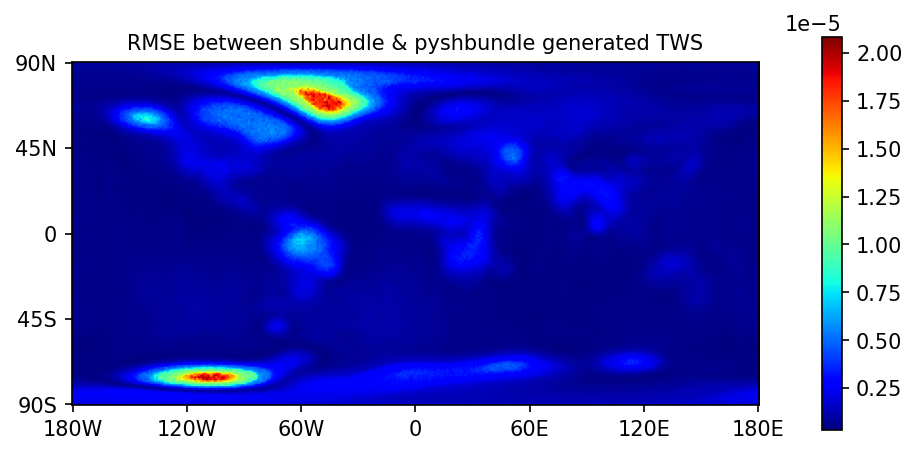

In [10]:
fig, (ax1) = plt.subplots(figsize=(6, 3), dpi=150, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax1)
ax1.set_xticks(np.linspace(0, 359, 7)) 
ax1.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])
ax1.set_yticks(np.linspace(0, 179, 5))
ax1.set_yticklabels(['90N', '45N', '0', '45S', '90S'])

im1 = ax1.imshow(gridwise_rmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax1, pad=0.0, shrink=0.9)
ax1.set_title('RMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=1.0)


plt.savefig('./figs/02_error_rmse.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
if np.all(gridwise_rmse < 1e-3):
    print('The two datasets are almost identical')

The two datasets are almost identical


## 2. Gridwise NRMSE

In [12]:
# Calculate the normalized root mean squared error (NRMSE)
gridwise_nrmse = gridwise_rmse/np.std(ds_msh['tws'].dropna(dim='time').values, axis=0)

array([[2.60043166e-08, 2.83013224e-08, 2.73803129e-08, ...,
        2.38515174e-08, 2.78223459e-08, 2.74585735e-08],
       [2.45173028e-08, 2.85903603e-08, 2.61927912e-08, ...,
        2.38695757e-08, 2.64437658e-08, 2.92895277e-08],
       [2.77640184e-08, 2.53198445e-08, 2.56853287e-08, ...,
        2.84399610e-08, 2.72859504e-08, 2.70947129e-08],
       ...,
       [2.97354718e-08, 3.33065197e-08, 3.47337847e-08, ...,
        3.32066023e-08, 3.68647979e-08, 3.25539337e-08],
       [3.43433379e-08, 3.48153238e-08, 3.33528178e-08, ...,
        3.62858782e-08, 3.30633574e-08, 3.46478197e-08],
       [3.42314674e-08, 2.61329397e-08, 3.27963439e-08, ...,
        3.12500385e-08, 3.01157924e-08, 3.60173407e-08]])

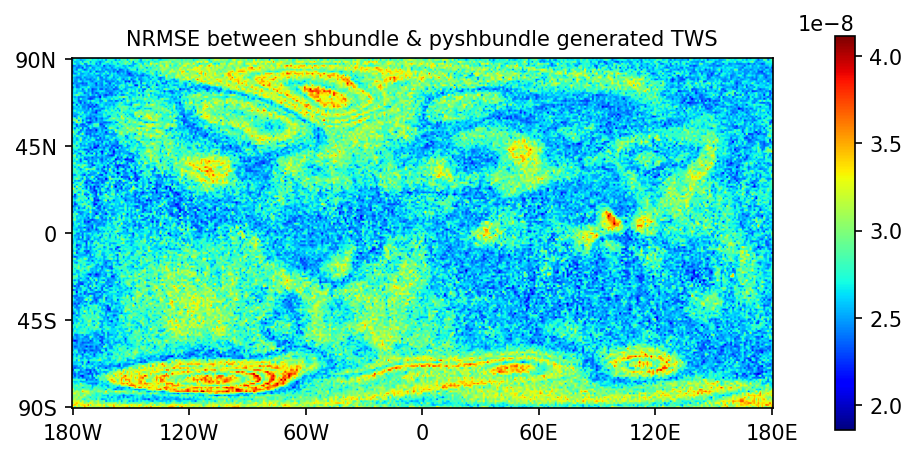

In [14]:
fig, (ax2) = plt.subplots(figsize=(6, 3), dpi=150, layout="constrained")    #gridspec_kw={'wspace': 0.01, 'hspace':0.2} 

# Set ticks and labels for the first subplot (ax2)
ax2.set_xticks(np.linspace(0, 359, 7))  # Adjust as needed
ax2.set_xticklabels(['180W', '120W', '60W', '0', '60E', '120E', '180E'])  # Adjust as needed
ax2.set_yticks(np.linspace(0, 179, 5))  # Adjust as needed
ax2.set_yticklabels(['90N', '45N', '0', '45S', '90S'])  # Adjust as needed

im1 = ax2.imshow(gridwise_nrmse, cmap='jet')
cbar1 = fig.colorbar(im1, ax=ax2, pad=0.0, shrink=0.9)
ax2.set_title('NRMSE between shbundle & pyshbundle generated TWS', fontsize=10, y=1)


plt.savefig('./figs/02_error_nrmse.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Global area weighted water budget closure

In [15]:
# Area of grids
from pyshbundle.hydro import area_weighting
global_grid_area=area_weighting(1)
global_grid_area_sum = np.sum(global_grid_area)
print('global surface area in m\u00b2:', global_grid_area_sum)

Initializing PySHbundle v0.3.0
global surface area in m²: 511207893395810.94


* Calculate the global area weighted water budget closure error

In [16]:
# Create a copy of the datasets
ds_msh_area_weighted, ds_pysh_area_weighted = ds_msh.copy(), ds_pysh.copy()

# Area weight with the global grid area and calculate the sum over lat and lon
ds_msh_area_weighted = ds_msh['tws']*global_grid_area / global_grid_area_sum
ds_msh_area_weighted = ds_msh_area_weighted.sum(dim=['lat', 'lon'])

# Same for the pyshbundle dataset
ds_pysh_area_weighted = ds_pysh['tws']*global_grid_area / global_grid_area_sum
ds_pysh_area_weighted = ds_pysh_area_weighted.sum(dim=['lat', 'lon'])

diff_global = ds_msh_area_weighted - ds_pysh_area_weighted

# Reinsert the NaN values where the GRACE data is missing and the time coordinate
ds_msh_area_weighted=ds_msh_area_weighted.where(~np.isnan(ds_pysh['tws'][:,0,0]), np.nan)
ds_pysh_area_weighted=ds_pysh_area_weighted.where(~np.isnan(ds_pysh['tws'][:,0,0]), np.nan)
diff_global=diff_global.where(~np.isnan(ds_pysh['tws'][:,0,0]), np.nan)

<xarray.DataArray 'tws' (time: 196)> Size: 2kB
array([ 5.87514242e-09, -4.26223627e-09, -1.39690889e-08, -7.80649822e-09,
       -6.42470429e-09, -8.19055354e-09,  6.63720314e-09,  9.31254960e-09,
       -5.73921703e-09,  1.89799448e-09,  8.24561639e-09,  3.79555209e-09,
        1.93735599e-09, -1.83972199e-09,  3.81898356e-09, -2.62595984e-09,
       -2.38502441e-09, -1.87216996e-10, -1.11288437e-09,  9.30366366e-10,
        2.59444324e-09,  2.16750338e-10,  2.78564623e-09, -7.79717517e-09,
        1.23423911e-09, -6.35305366e-09,  1.16946797e-10,  1.88048715e-09,
       -4.28015162e-09, -2.50727195e-09,  9.53246503e-09,  6.83303813e-09,
        2.47475427e-09,  8.28576528e-10, -1.35008986e-09, -1.28247128e-09,
       -5.63241678e-09,  2.24805231e-09, -3.87196555e-10, -6.36321565e-09,
       -6.67633858e-09,  1.87588679e-09,  2.03895521e-09,  2.05828367e-09,
        1.07927121e-11, -1.64327905e-09,  2.35859809e-09,  3.71154031e-10,
       -2.67425211e-09, -6.57371404e-09,  5.83918020e-10, -2.58793085e-09,
       -1.10072471e-09,  3.78740363e-09,  1.29334811e-09, -3.38107645e-09,
        7.70597853e-11,  3.39068548e-11, -9.98683181e-09, -6.64013796e-09,
       -7.95609364e-12, -1.23654871e-09, -1.55860070e-09, -2.62608386e-09,
        5.01679307e-09, -3.52707908e-09, -6.91500705e-09, -1.66992629e-09,
        1.49260014e-10,  4.41058990e-09, -2.50259149e-09, -1.05710635e-08,
       -5.70400550e-09,  3.75981063e-09,  1.72891964e-09,  4.58359305e-09,
       -6.86300811e-09,  3.69887100e-09,  9.94802864e-09, -6.34540876e-09,
...
       -1.11768902e-09, -3.87988484e-09,  1.34124587e-08, -1.02895904e-08,
        1.17854943e-08,  4.70972124e-10,  2.21671436e-09,  2.73956553e-09,
       -1.18020195e-09,  2.38018681e-10,  6.36812381e-09, -1.67224391e-09,
       -6.25125249e-09, -2.01698382e-09,  8.31228049e-09, -5.87187740e-09,
        1.25964770e-09, -1.22692640e-09,  6.42588051e-09, -2.44977039e-09,
       -3.71793112e-09,  3.94672049e-09,  2.38468517e-09, -7.19730792e-10,
        9.95087958e-09,  1.84939524e-09,  4.66824203e-09,  1.02633004e-08,
       -6.80598554e-09,  1.77905552e-08,  8.67085266e-09,  1.34698485e-08,
        1.69740135e-10, -1.13187689e-08,  6.77686765e-09, -2.11015178e-10,
        8.87092181e-09,  6.98568608e-10, -1.24434164e-08,  1.12154009e-08,
        6.78988250e-09, -1.17979583e-09, -1.28954413e-09,  3.04643606e-10,
        4.69958849e-09,  4.11638867e-09,  1.30736892e-08, -1.37415186e-08,
        1.06418072e-08,  9.08527564e-09,  4.90118193e-09,  6.11483914e-09,
       -6.40441328e-09,  1.84915147e-08, -6.10342800e-09,  6.43397894e-09,
        1.89346129e-08,  4.24687298e-09,  3.45359202e-09,  2.99639133e-10,
       -7.83841821e-10,  4.93612486e-09, -2.34304746e-09,  4.80692647e-09,
       -9.03242491e-09, -2.54978475e-09,  6.18848239e-09,  1.40658390e-08,
       -4.17258348e-09,  6.13656311e-09,  4.88619985e-09,  1.56514421e-08,
        3.92759882e-09, -5.24303300e-09,  1.21710124e-08,  8.05693334e-09,
        9.01684360e-10,  8.92289255e-09,  1.87684341e-09, -1.58011433e-08])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30
    lat      int64 8B 89
    lon      int64 8B -180

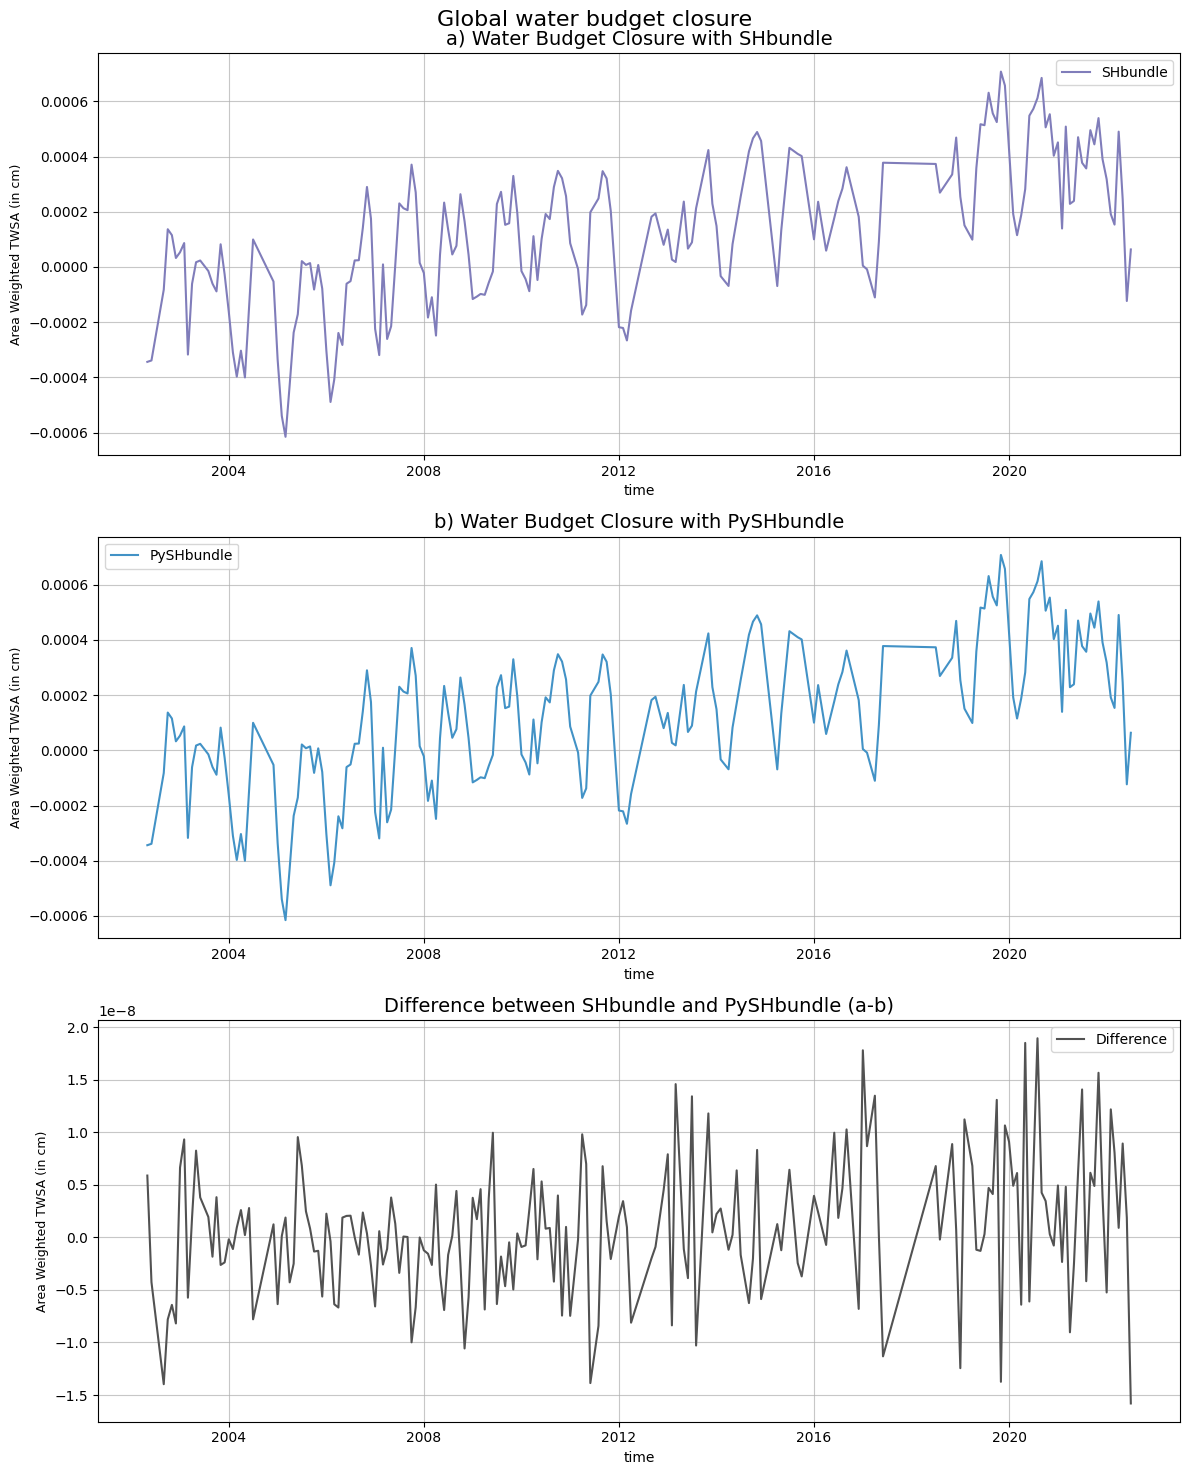

In [17]:
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15),)
fig.suptitle('Global water budget closure', fontsize=16)

# Plot 1
ds_msh_area_weighted.plot(ax=axes[0], color='#807dba', label='SHbundle')
axes[0].set_title('a) Water Budget Closure with SHbundle', fontsize=14)
axes[0].set_ylabel('Area Weighted TWSA (in cm)', fontsize=9)
axes[0].legend()
axes[0].grid(True, alpha=0.7)

# Plot 2
ds_pysh_area_weighted.plot(ax=axes[1], color='#4292c6', label='PySHbundle')
axes[1].set_title('b) Water Budget Closure with PySHbundle', fontsize=14)
axes[1].set_ylabel('Area Weighted TWSA (in cm)', fontsize=9)
axes[1].legend()
axes[1].grid(True, alpha=0.7)

# Plot 3
diff_global.plot(ax=axes[2], color='#525252', label='Difference')
axes[2].set_title('Difference between SHbundle and PySHbundle (a-b)', fontsize=14)
axes[2].set_ylabel('Area Weighted TWSA (in cm)', fontsize=9)
axes[2].legend()
axes[2].grid(True, alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## 4. Difference in basin-average Time Series

In [18]:
import geopandas as gpd

<Axes: >

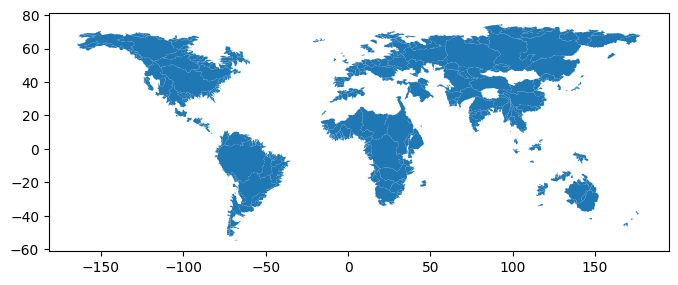

In [19]:
path_shapefile = '../pyshbundle/data/mrb_shapefiles/mrb_basins.shp'
shp = gpd.read_file(path_shapefile)
shp.plot(figsize=(8, 4))  

     MRBID RIVER_BASI CONTINENT            SEA         OCEAN  SUM_SUB_AR  \
115   2312    KRISHNA      Asia  Bay of Bengal  Indian Ocean    258785.1   

     Shape_Leng  Shape_Area                                           geometry  
115   36.078865   21.832582  POLYGON ((73.99167 19.37917, 73.99202 19.37674...   

Basin area is : 258785100000.0 m²


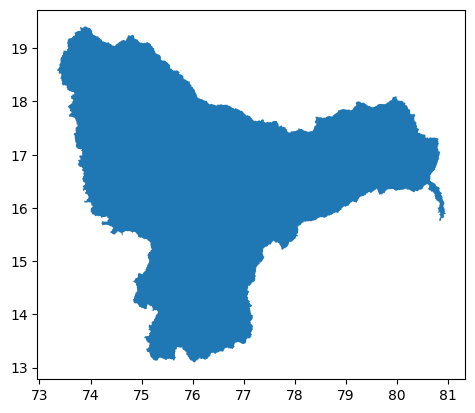

In [20]:
basin_name='KRISHNA'
shp_basin=shp[shp['RIVER_BASI']==basin_name]
print(shp_basin.head(), '\n')
shp_basin.plot()
basin_area=np.float64(shp_basin['SUM_SUB_AR'].values[0])*1e6          # basin area already in m^2
print('Basin area is :', basin_area, 'm\u00b2');

In [21]:
from pyshbundle.hydro import Basinaverage
_, basin_avg_tws_msh = Basinaverage(ds_msh, gs, shp_basin, basin_area)
_, basin_avg_tws_pysh = Basinaverage(ds_pysh, gs, shp_basin, basin_area)

In [22]:
new_dates=pd.date_range(start=basin_avg_tws_msh.time[0].values, 
                        end=basin_avg_tws_msh.time[-1].values, freq='ME',)
new_dates

DatetimeIndex(['2002-04-30', '2002-05-31', '2002-06-30', '2002-07-31',
               '2002-08-31', '2002-09-30', '2002-10-31', '2002-11-30',
               '2002-12-31', '2003-01-31',
               ...
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30'],
              dtype='datetime64[ns]', length=243, freq='ME')

In [23]:
# Empty dataset for the gapped data, msh
basin_avg_tws_gapped_msh = xr.Dataset(
        data_vars = dict(   tws=(["time"], np.nan*np.arange(len(new_dates)))),
        coords=dict(time=new_dates),);
# Empty dataset for the gapped data, pysh
basin_avg_tws_gapped_pysh = xr.Dataset(
        data_vars = dict(   tws=(["time"], np.nan*np.arange(len(new_dates)))),
        coords=dict(time=new_dates),);

In [24]:
#
basin_avg_tws_gapped_msh['tws'] = basin_avg_tws_msh['tws'].where(
    basin_avg_tws_msh['time'].isin(basin_avg_tws_gapped_msh['time']),)
#
basin_avg_tws_gapped_pysh['tws'] = basin_avg_tws_pysh['tws'].where(
    basin_avg_tws_pysh['time'].isin(basin_avg_tws_gapped_pysh['time']),)

diff_global_basin = basin_avg_tws_gapped_msh['tws'] - basin_avg_tws_gapped_pysh['tws']

<xarray.DataArray 'tws' (time: 243)> Size: 2kB
array([-9.69094529e-07,  2.36812042e-07,             nan,             nan,
        8.72978152e-08, -1.22263451e-07,  4.77928275e-08,  6.80909089e-08,
       -1.37740276e-07,  1.01072999e-08, -7.46400161e-07,  9.89647361e-07,
        5.14377902e-07, -2.70129902e-07,             nan, -6.01012488e-07,
       -3.09933981e-08,  6.28074375e-07, -5.55916685e-07,  3.76842447e-07,
       -5.70394079e-08,  2.17199208e-07,  3.39967215e-07,  8.08937116e-07,
        1.29339418e-06,  5.10734992e-07, -9.80370345e-08,             nan,
                   nan,             nan,             nan,  1.06307496e-07,
        8.68036309e-09, -7.27863338e-07,  2.53009333e-07, -1.59850345e-07,
       -2.06998760e-06,  8.39926741e-07, -2.76245459e-07,  9.98629304e-08,
        7.68413599e-07,  5.36044709e-07, -6.23643089e-07, -3.18224664e-07,
       -5.31668150e-08, -1.18423031e-08, -7.10703212e-08, -5.07394873e-08,
        3.89335582e-07,  1.04053072e-07,  4.57618640e-07, -4.59484362e-09,
        2.88781294e-07, -1.25456124e-06,  7.81874121e-09,  1.07865930e-07,
       -3.85457177e-07,  2.34572131e-08, -2.31180174e-07, -3.60701080e-07,
        2.07377070e-07, -1.33825765e-07, -5.05677363e-07,  4.24036536e-07,
        1.33390401e-07,  1.30523659e-07,  9.86716245e-07, -2.10345803e-08,
        7.35452730e-08, -8.95017749e-09, -9.91731675e-08,  1.29662244e-07,
       -1.78431570e-07, -5.90120649e-07,  1.17968489e-06, -3.21184501e-08,
       -1.75152451e-07,  6.74823468e-07,  6.38817767e-07, -3.48368417e-07,
...
       -1.13959693e-07,  7.35506944e-08,             nan, -5.70835113e-08,
                   nan, -1.35550025e-06, -2.58927741e-08,  1.28360909e-07,
       -1.60221802e-07,             nan,             nan, -7.22614857e-10,
        1.00813597e-07,  8.52889684e-07,             nan,  2.22721461e-07,
        9.06335572e-07, -2.43086902e-07,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,  8.60203485e-07,  4.81101566e-07,
                   nan,             nan,  4.96292998e-08, -3.21344373e-08,
       -1.32220993e-07, -1.40416368e-07,             nan,  3.48717322e-08,
       -5.65086509e-07,  1.99339013e-07,  1.42135383e-06, -1.75112262e-07,
        1.64046334e-07,  4.76149893e-07, -6.60354260e-08, -1.97107710e-07,
        3.18719103e-07, -2.36057595e-07, -2.61367182e-08,  1.02312743e-07,
        1.44168624e-08, -2.41245061e-07,  1.09676563e-07,  1.71292669e-08,
       -4.57230357e-07,  3.95559994e-07, -2.18310092e-06, -4.80689124e-07,
       -8.21612119e-07, -6.15576880e-07, -1.20758642e-07, -3.08953387e-08,
        1.51928063e-07,  4.51007708e-07,  4.07144896e-09,  3.63877753e-07,
       -2.96939973e-07,  6.93324552e-07,  8.75828334e-08, -6.22073145e-07,
        6.41594710e-07, -5.43634883e-07,  6.60334599e-07, -3.24580469e-08,
       -2.22809993e-09,  1.79623873e-07, -1.27318494e-08])
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-04-30 2002-05-31 ... 2022-06-30

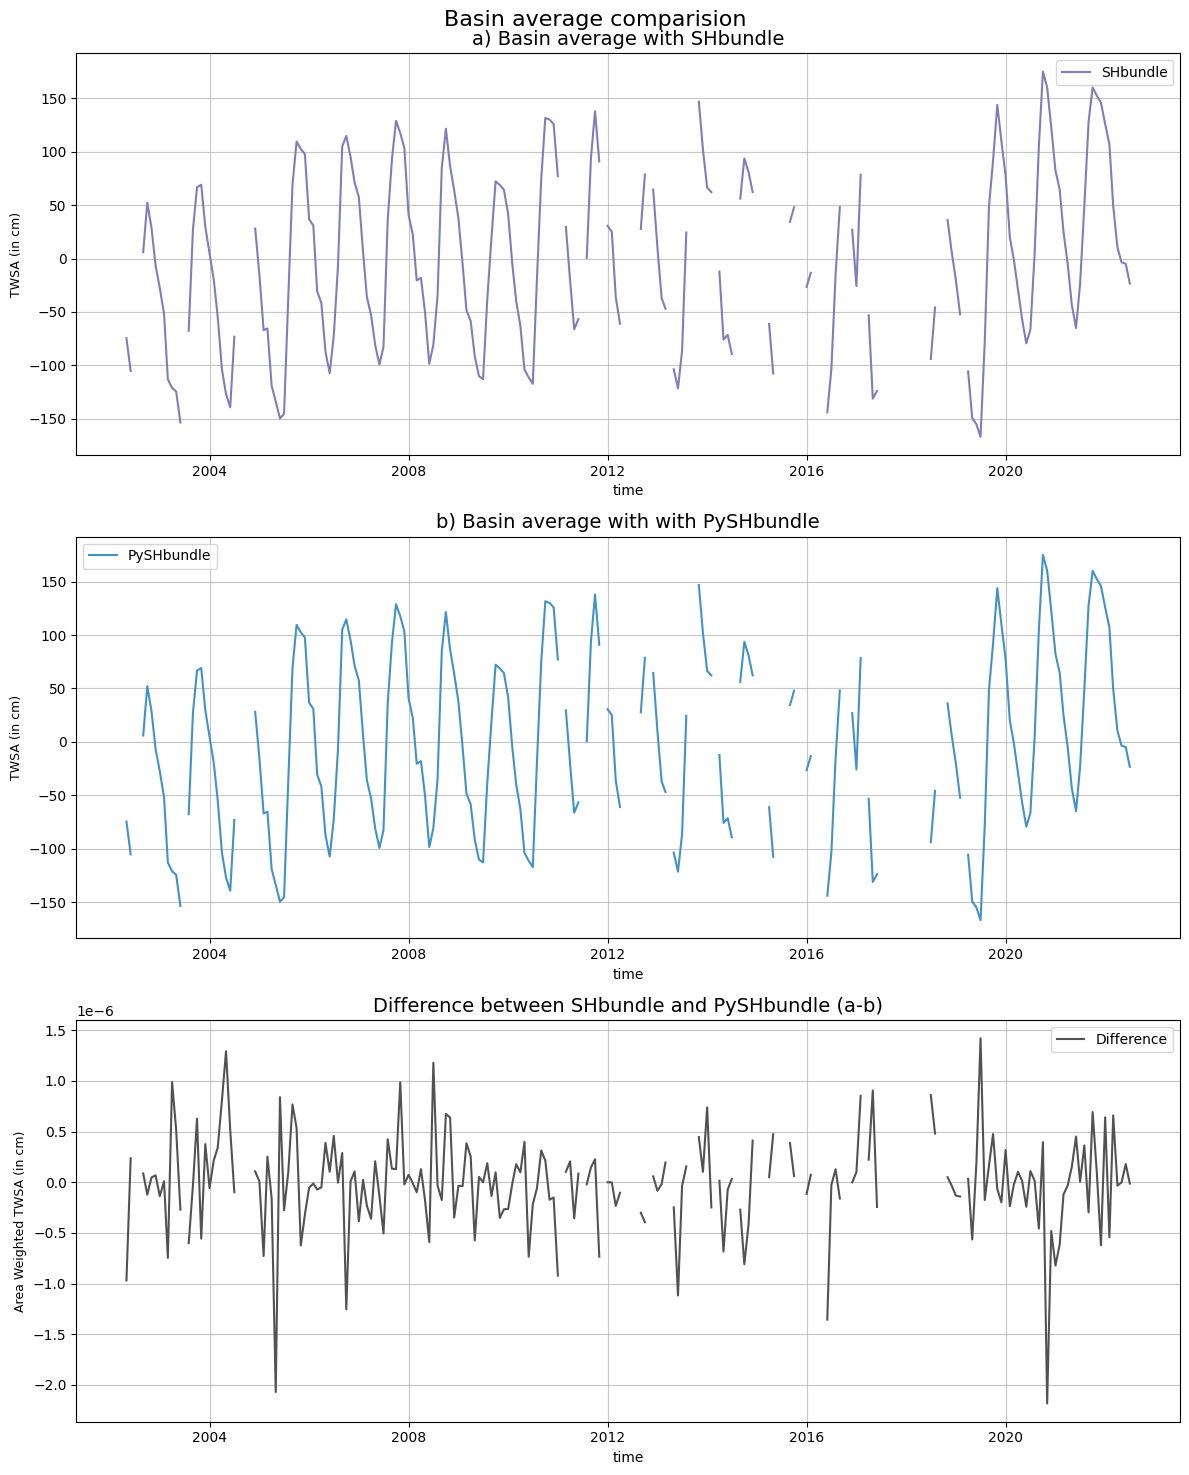

In [25]:
# Create a figure with three subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15),)
fig.suptitle('Basin average comparision', fontsize=16)

# Plot 1
basin_avg_tws_gapped_msh['tws'].plot(ax=axes[0], color='#807dba', label='SHbundle')
axes[0].set_title('a) Basin average with SHbundle', fontsize=14)
axes[0].set_ylabel('TWSA (in cm)', fontsize=9)
axes[0].legend()
axes[0].grid(True, alpha=0.7)

# Plot 2
basin_avg_tws_gapped_pysh['tws'].plot(ax=axes[1], color='#4292c6', label='PySHbundle')
axes[1].set_title('b) Basin average with with PySHbundle', fontsize=14)
axes[1].set_ylabel('TWSA (in cm)', fontsize=9)
axes[1].legend()
axes[1].grid(True, alpha=0.7)

# Plot 3
diff_global_basin.plot(ax=axes[2], color='#525252', label='Difference')
axes[2].set_title('Difference between SHbundle and PySHbundle (a-b)', fontsize=14)
axes[2].set_ylabel('Area Weighted TWSA (in cm)', fontsize=9)
axes[2].legend()
axes[2].grid(True, alpha=0.7)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

* Thank you for reading!